In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Importing necessary libraries

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

#### Preparing the data

In [6]:
train_data_path = r'/kaggle/input/sports-classification/train'
test_data_path = r'/kaggle/input/sports-classification/test'
val_data_path = r'/kaggle/input/sports-classification/valid'

In [68]:
# Preparing the training dataset
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_path,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    subset="training",
    validation_split=0.2,
    seed=50,
    shuffle=True,
)

# Preparing the validation dataset
val_data = tf.keras.utils.image_dataset_from_directory(
    val_data_path,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    subset="validation",
    validation_split=0.2,
    seed=50,
    shuffle=True,
)

# Preparing the test dataset
test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_path,
    batch_size=32,
    image_size=(224, 224),
    color_mode="rgb",
)
classes = train_data.class_names

Found 13492 files belonging to 100 classes.
Using 10794 files for training.
Found 500 files belonging to 100 classes.
Using 100 files for validation.
Found 500 files belonging to 100 classes.


#### Displaying images present in the training data

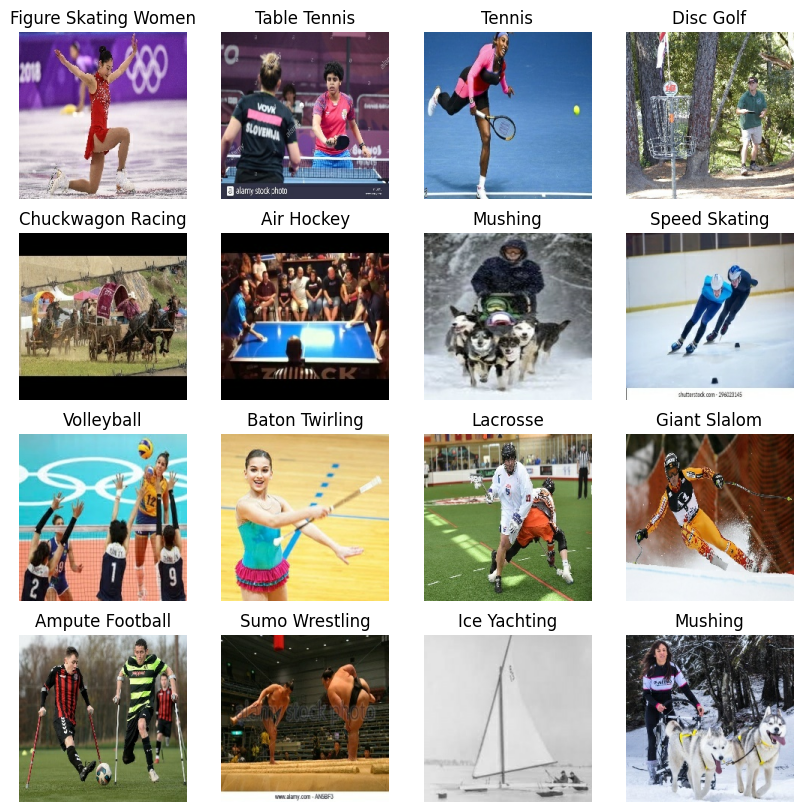

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]].title())
        plt.axis("off")
plt.show()

#### Defining the model

In [45]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

In [69]:
# EfficientNetB0 base model
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(classes), activation='softmax')(x)
model = models.Model(inputs, outputs)

# Compiling the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [70]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │         128,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,177,671 (15.94 MB)

 Trainable params: 4,135,648 (15.78 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [49]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [71]:
model.fit(train_data, epochs=10, validation_data=val_data, batch_size=64, callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1750778310.540476     107 service.cc:148] XLA service 0x7ceed0002520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750778310.543066     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750778310.543092     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750778315.506317     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1750778325.900165     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750778326.044555     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750778326.517588     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5311 - loss: 2.0977

E0000 00:00:1750778396.743368     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750778396.881064     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


338/338 ━━━━━━━━━━━━━━━━━━━━ 169s 240ms/step - accuracy: 0.5321 - loss: 2.0926 - val_accuracy: 0.8300 - val_loss: 0.5815
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.8956 - loss: 0.3730 - val_accuracy: 0.8900 - val_loss: 0.3394
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 42s 123ms/step - accuracy: 0.9392 - loss: 0.2030 - val_accuracy: 0.9000 - val_loss: 0.5570
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 43s 126ms/step - accuracy: 0.9385 - loss: 0.2025 - val_accuracy: 0.9400 - val_loss: 0.2405
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.9556 - loss: 0.1514 - val_accuracy: 0.9000 - val_loss: 0.3246
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/step - accuracy: 0.9579 - loss: 0.1401 - val_accuracy: 0.9300 - val_loss: 0.2586
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 45s 132ms/step - accuracy: 0.9664 - loss: 0.1088 - val_accuracy: 0.9200 - val_loss: 0.2288
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - accuracy: 0.9744 - loss: 0.0828 - va

#### Fine-tuning the model

In [74]:
base_model.trainable = True
# Re-compiling with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [75]:
# Fitting the model again
model_history = model.fit(train_data, epochs=10, validation_data=val_data, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 157s 227ms/step - accuracy: 0.9705 - loss: 0.1052 - val_accuracy: 0.9300 - val_loss: 0.3278
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.9789 - loss: 0.0690 - val_accuracy: 0.9400 - val_loss: 0.2946
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.9831 - loss: 0.0570 - val_accuracy: 0.9400 - val_loss: 0.2807
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.9891 - loss: 0.0398 - val_accuracy: 0.9400 - val_loss: 0.2696
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 129ms/step - accuracy: 0.9920 - loss: 0.0358 - val_accuracy: 0.9400 - val_loss: 0.2592
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - accuracy: 0.9923 - loss: 0.0302 - val_accuracy: 0.9400 - val_loss: 0.2536
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - accuracy: 0.9942 - loss: 0.0239 - val_accuracy: 0.9400 - val_loss: 0.2462
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 45s 134ms/step - accuracy: 0.9949 - loss: 

In [76]:
import joblib
model.save('classifier.keras')
joblib.dump(classes, 'class_list.pkl')

['class_list.pkl']

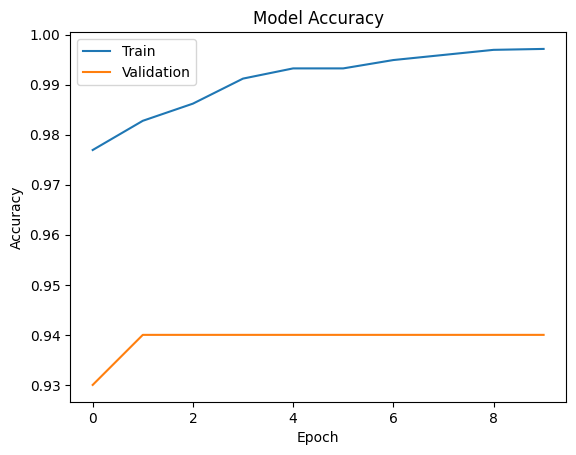

In [77]:
# Accuracy history summary
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

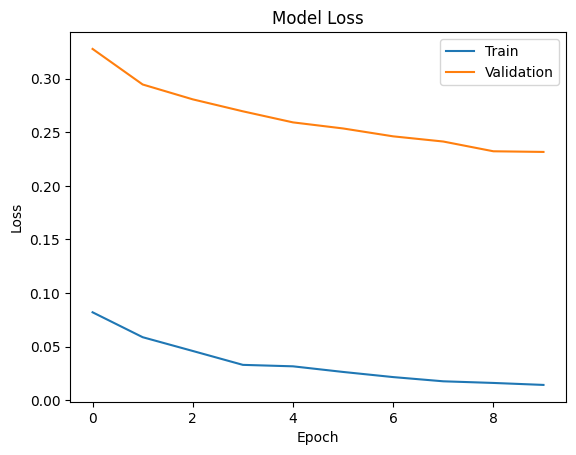

In [78]:
# Loss history summary
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

#### Metrics

In [84]:
validation_accuracy = model.evaluate(val_data)
test_accuracy = model.evaluate(test_data)

print(f"validation accuracy : {validation_accuracy[1]:0.4f}")
print(f"test accuracy : {test_accuracy[1]:0.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9260 - loss: 0.2870
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9715 - loss: 0.1035
validation accuracy : 0.9400
test accuracy : 0.9720
